In [1]:
%matplotlib inline
import torch
import os.path
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import pylab
from torch.autograd import Variable
import torch.nn as nn
pylab.rcParams['figure.figsize']=(8.0, 10.0)

In [2]:
import sys
sys.path.append('/project/xychen/datasets/mscoco/coco/PythonAPI')
from pycocotools.coco import COCO

In [3]:
root='/project/xychen/datasets/mscoco'
dataType='train2017'
A_cats='zebra'
B_cats='horse'
index1=100
index2=101

## load images and segmentation
**return: A_input** type:torch.FloatTensor size:4 x height x width (RGBA)

In [4]:
transform_list = [transforms.ToTensor(),
                   transforms.Normalize((0.5, 0.5, 0.5),
                                        (0.5, 0.5, 0.5))]
transform=transforms.Compose(transform_list)

In [5]:
annFile='{}/annotations/instances_{}.json'.format(root,dataType)
coco = COCO(annFile)

loading annotations into memory...
Done (t=20.02s)
creating index...
index created!


In [52]:
def getSegMask(anns):
    for i,anns_i in enumerate(anns):
        if i==0:
            mask=np.asarray(coco.annToMask(anns_i))
        else:
            mask+=np.asarray(coco.annToMask(anns_i))
    mask[mask>1]=1
    mask=torch.from_numpy(mask[np.newaxis,:,:]*255)
    ToPil=transforms.ToPILImage()
    seg=ToPil(mask)
    return seg

# get image
interpolation=Image.BICUBIC
size=(224,224)
def get_img(index,cat,mask_out=True):
    catId = coco.getCatIds(catNms=[cat])
    imgIds = coco.getImgIds(catIds=catId)
    cat_size = len(imgIds) # numbers of images 
    index = index % cat_size
    img_id = imgIds[index]
    ann_ids = coco.getAnnIds(imgIds=img_id, catIds=catId, iscrowd=None)
    anns = coco.loadAnns(ann_ids)
    path = coco.loadImgs(img_id)[0]['file_name']
    path = os.path.join(root, dataType, path)
    img = Image.open(path).convert('RGB')
    if mask_out:
        seg = getSegMask(anns)
        img.putalpha(seg)
    return img.resize(size, interpolation)

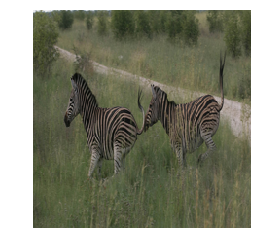

In [53]:
img_1=get_img(index1,A_cats,mask_out=False)
# show image 
plt.axis('off')
plt.imshow(img_1)
plt.show()

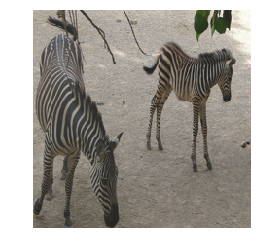

In [45]:
img_2=get_img(index2,A_cats,mask_out=False)
# show image 
plt.axis('off')
plt.imshow(img_2)
plt.show()

In [55]:
img_2.size

(224, 224)

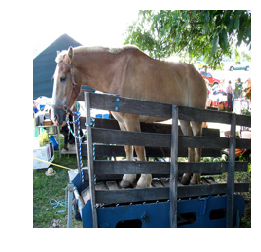

In [56]:
img_3=get_img(5,B_cats,mask_out=False)
# show image 
plt.axis('off')
plt.imshow(img_3)
plt.show()

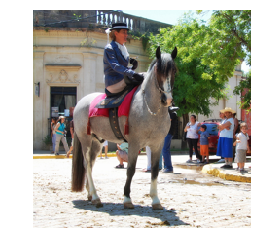

In [57]:
img_4=get_img(19,B_cats,mask_out=False)
# show image 
plt.axis('off')
plt.imshow(img_4)
plt.show()

In [58]:
input_1 = transform(img_1)
input_2 = transform(img_2)
input_3 = transform(img_3)
input_4 = transform(img_4)

## load VGG and extract feature

In [61]:
vgg16=models.vgg16(pretrained=True)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [84]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [91]:
feat_extractor1=nn.Sequential(*list(vgg16.features))
#feat_extractor2=nn.Sequential(*list(vgg16.classifier.children())[:1])
feat_extractor2=nn.Sequential(*list(vgg16.classifier))
#input_1=torch.from_numpy(input_1[:3].numpy()*input_1[3].numpy())
#input_2=torch.from_numpy(input_2[:3].numpy()*input_2[3].numpy())
img1=normalize(input_1).unsqueeze(0)
img2=normalize(input_2).unsqueeze(0)

In [92]:
img1=Variable(img1)
feat_1=feat_extractor1(img1).view(img1.size(0), -1)

feat_1=feat_extractor2(feat_1)

img2=Variable(img2)
feat_2=feat_extractor1(img2).view(img2.size(0),-1)
feat_2=feat_extractor2(feat_2)

In [95]:
feat_1.size()

torch.Size([1, 1000])

In [93]:
print(torch.norm(img1-img2))
print(torch.norm(feat_1-feat_2))

tensor(155147.5156)
tensor(4491.4941, grad_fn=<NormBackward0>)


In [96]:
img3=normalize(input_3).unsqueeze(0)
img4=normalize(input_4).unsqueeze(0)
img3=Variable(img3)
feat_3=feat_extractor1(img3).view(img3.size(0), -1)

feat_3=feat_extractor2(feat_3)

img4=Variable(img4)
feat_4=feat_extractor1(img4).view(img4.size(0),-1)
feat_4=feat_extractor2(feat_4)

In [97]:
print(torch.norm(img3-img4))
print(torch.norm(feat_3-feat_4))
print(torch.norm(feat_1-feat_3))
print(torch.norm(feat_2-feat_3))

tensor(68689.2891)
tensor(1310.8756, grad_fn=<NormBackward0>)
tensor(5920.0830, grad_fn=<NormBackward0>)
tensor(6936.2427, grad_fn=<NormBackward0>)


In [98]:
print(torch.norm(img1-img3))
print(torch.norm(img2-img3))

tensor(261472.6250)
tensor(184886.6875)


In [9]:
mask_1 = torch.nn.functional.interpolate(input_1[3].unsqueeze(0).unsqueeze(0),scale_factor=1/32)
mask_2 = torch.nn.functional.interpolate(input_2[3].unsqueeze(0).unsqueeze(0),scale_factor=1/32)

NameError: name 'input_1' is not defined

In [41]:
masked_feat1=feat_1_all*mask_1
masked_feat2=feat_2_all*mask_2

In [42]:
torch.norm(masked_feat1-masked_feat2)

tensor(205.5989, grad_fn=<NormBackward0>)

In [45]:
masked_feat1=feat_1_all*mask_2
masked_feat2=feat_2_all*mask_1

In [46]:
torch.norm(masked_feat1-masked_feat2)

tensor(176.7495, grad_fn=<NormBackward0>)

## load Resnet 18

In [13]:
resnet18=models.resnet18(pretrained=True)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [14]:
img1_all=input_1[:3]
img2_all=input_2[:3]

img1_all=normalize(img1_all).unsqueeze(0)
img2_all=normalize(img2_all).unsqueeze(0)

In [15]:
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co